compare tasks (cookieTheft, picnicScene, journaling) to see which task's feature set best predicts a target score


In [7]:
# setup
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patheffects as pe
from pandas.api.types import CategoricalDtype

# add project root
sys.path.append("/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/src")

from config.constants import GIT_DIRECTORY
from regression.plotting_helpers import (
    format_title, make_task_palette, make_model_palette, shrink_seaborn_boxes,
    plot_bootstrap_score_comparison, plot_bootstrap_model_violin,
    plot_bootstrap_model_box, plot_bootstrap_score_boxplot,
    plot_bootstrap_model_violin_standard, plot_bootstrap_score_violin_standard,
    plot_bootstrap_mean_ci_models, plot_bootstrap_mean_ci_scores,
    plot_models_mean_ci_single, plot_models_box_single, plot_models_violin_standard_single, plot_models_violin_single
)

# paths
oof_dir   = os.path.join(GIT_DIRECTORY, "results", "oof_results2")
save_path = os.path.join(GIT_DIRECTORY, "results", "regression", "model_comparison", "filtered2", "tasks")
os.makedirs(save_path, exist_ok=True)

# parameters
target      = "PictureNamingScore"
task_order  = ["cookieTheft", "picnicScene", "journaling"]
model_order = ["baseline","demographics","acoustic","linguistic","linguistic+acoustic","full"]
all_scores  = ["PictureNamingScore","SemanticFluencyScore","PhonemicFluencyScore"]
all_tasks   = task_order
palette     = make_task_palette(task_order)


In [8]:
# core predictions (all scores, all models, all tasks)
oof_all = pd.read_csv(os.path.join(oof_dir, "oof_preds_all_scores.csv"))

# per-target subset (model-comparison plots)
oof_target = oof_all[oof_all["target"] == target].copy()

# folds + bootstrap summary
df_folds    = pd.read_csv(os.path.join(oof_dir, "cv_folds_all_scores.csv")) # r2/rmse/mae per fold
oof_summary = pd.read_csv(os.path.join(oof_dir, f"bootstrap_summary_{target}.csv")) # r2_oof + CI per model×task

# subject pool used to fit/score this target
subject_set = set(pd.read_csv(os.path.join(oof_dir, f"{target}_full_subjects.csv"))["Subject_ID"])

# intersection of subjects for comparison across scores
def load_subject_pool_for_scores(oof_dir, scores):
    pools = [set(pd.read_csv(os.path.join(oof_dir, f"{s}_full_subjects.csv"))["Subject_ID"]) for s in scores]
    return set.intersection(*pools)
subjects_all_scores = load_subject_pool_for_scores(oof_dir, all_scores)


In [ ]:
def plot_mean_plus_fold_r2(oof_summary, df_folds, save_path=None, target=None, model_type_name="RandomForestRegressor"):

    sns.set_theme(style="whitegrid", context="paper")

    oof = oof_summary.copy()
    oof["model"] = oof["model"].astype(CategoricalDtype(categories=model_order, ordered=True))
    oof["task"]  = oof["task"].astype(CategoricalDtype(categories=task_order,  ordered=True))

    folds = (
        df_folds.loc[df_folds["target"] == target, ["task","model","fold","r2"]]
        .drop_duplicates(subset=["task","model","fold"])
        .copy()
    )
    folds["model"] = folds["model"].astype(CategoricalDtype(categories=model_order, ordered=True))
    folds["task"]  = folds["task"].astype(CategoricalDtype(categories=task_order,  ordered=True))

    # plot
    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    ax.tick_params(axis="x", labelsize=10) # (model names)
    ax.tick_params(axis="y", labelsize=10)

    # R^2 for each of the five folds
    sns.stripplot(
        data=folds,
        x="model",
        y="r2",
        hue="task",
        dodge=True,
        jitter=0.1,
        size=7,
        alpha=0.8,
        palette=palette,
        edgecolor=None,
        zorder=3
    )

    LABEL_DX = -3 # horizontal nudge in points (px)
    LABEL_DY = 1 # vertical nudge in points (px)

    # add mean R^2 (oof)
    offsets = np.linspace(-0.25, 0.25, len(task_order))
    for _, row in oof.iterrows():
        x_idx = model_order.index(row["model"]); h_idx = task_order.index(row["task"])
        x_pos = x_idx + offsets[h_idx]
        ax.plot([x_pos], [row["r2_oof"]], marker="o", markersize=6, color="black", zorder=7)

        ax.annotate(
            f"{row['r2_oof']:.2f}",
            xy=(x_pos, row["r2_oof"]), # anchor at the dot
            xytext=(LABEL_DX, LABEL_DY), # nudge from the dot
            textcoords="offset points",
            ha="right", va="bottom",
            fontsize=10, zorder=8
        )

    ax.axhline(0, color="#777", lw=0.8, ls="--", zorder=10, clip_on=False)
    plt.title(f"Model Comparison (R²): {format_title(target)}", fontsize=14, fontweight="bold")
    plt.ylabel("R² (Mean + Folds)", fontsize=12)
    plt.xlabel("Model", fontsize=12)
    plt.tight_layout()

    # remove double legend
    handles, labels = ax.get_legend_handles_labels()
    if ax.legend_:
        ax.legend_.remove()
        plt.legend(handles[:len(task_order)], labels[:len(task_order)], title="Task", loc="upper left", fontsize=10)

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(os.path.join(save_path, f"model_comparison_folds_{target}_{model_type_name}.png"), dpi=300, bbox_inches="tight")

    plt.show()


In [ ]:
# plot per-fold R^2-distribution
df_folds = pd.read_csv(os.path.join(oof_dir, "cv_folds_all_scores.csv"))
oof_summary = pd.read_csv(os.path.join(oof_dir, f"bootstrap_summary_{target}.csv"))
plot_mean_plus_fold_r2(oof_summary, df_folds, save_path=save_path, target=target, model_type_name="RandomForestRegressor")

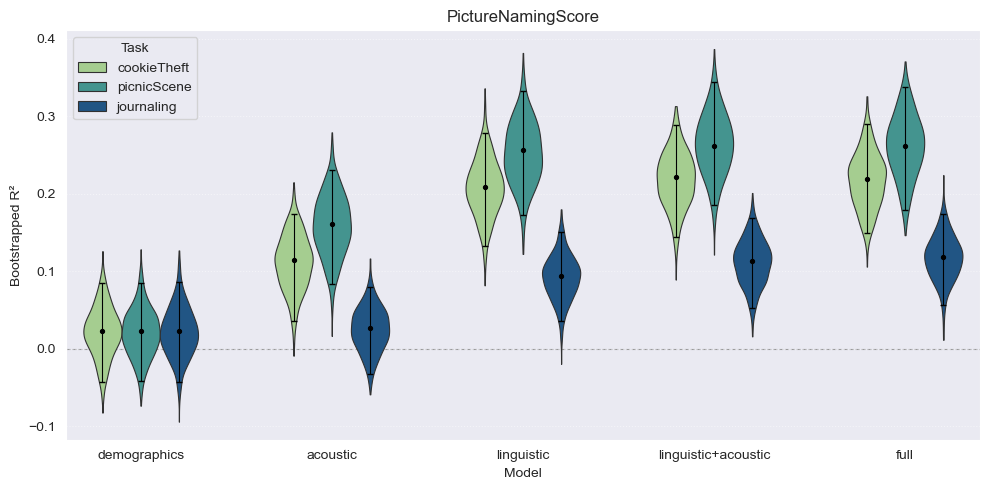

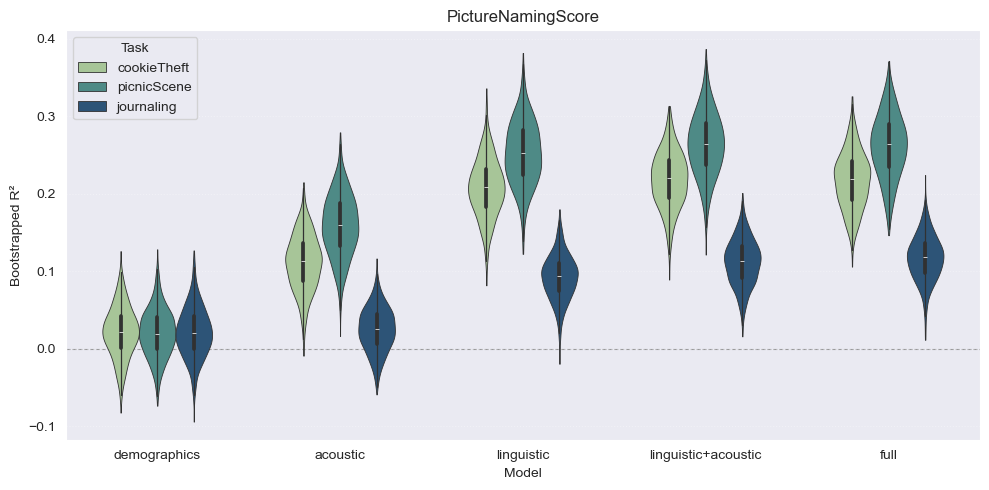

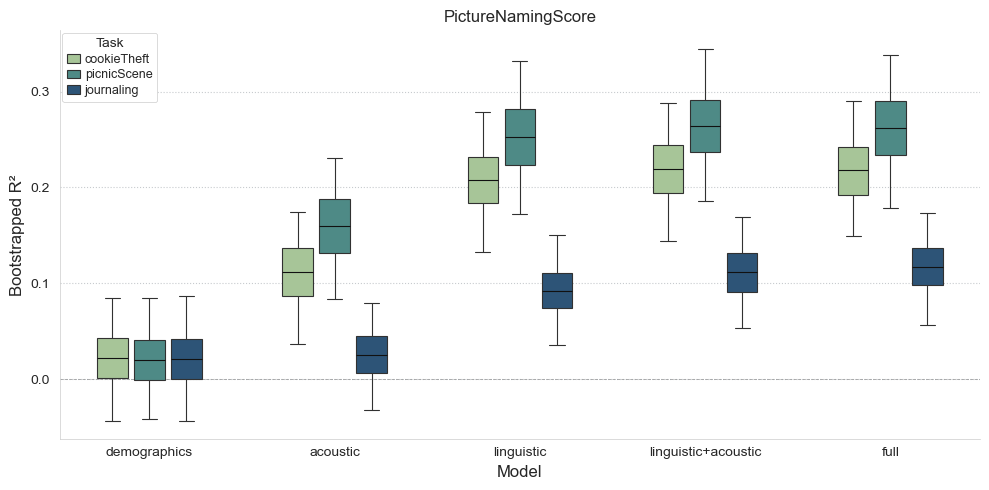

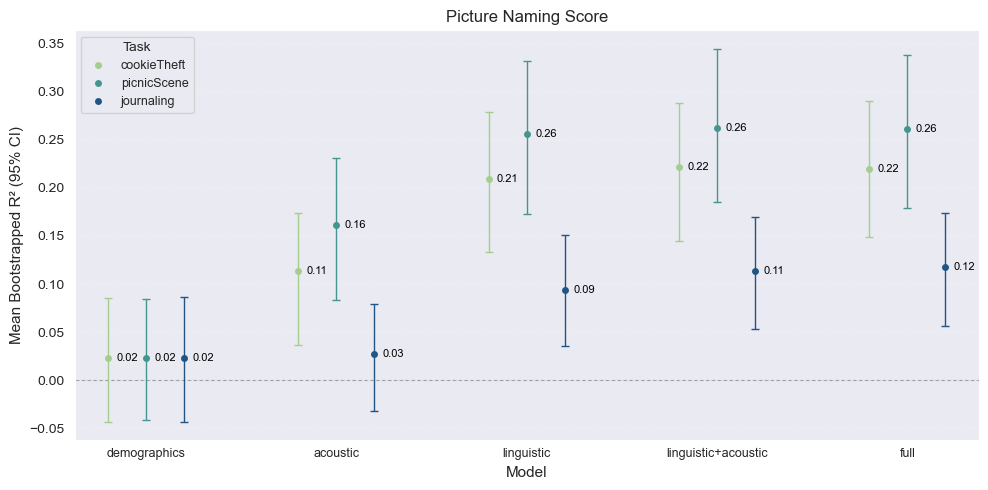

In [9]:
# model comparisons
plot_bootstrap_model_violin(
    oof_target, target=target,
    order_models=model_order, order_tasks=task_order,
    subject_set=subject_set,
    drop_models=["baseline"],
    save_path=save_path
)

plot_bootstrap_model_violin_standard(
    oof_target,
    target=target,
    order_models=model_order[1:],
    order_tasks=task_order,
    subject_set=subject_set,
    save_path=save_path
)

plot_bootstrap_model_box(
    oof_target,
    target=target,
    order_models=model_order[1:],
    order_tasks=task_order,
    subject_set=subject_set,
    save_path=save_path
)

plot_bootstrap_mean_ci_models(
    oof_target, target=target,
    order_models=model_order,
    order_tasks=task_order,
    drop_models=["baseline"],
    save_path=save_path
)

In [ ]:
# score comparisons
plot_bootstrap_score_comparison(
    oof_all,
    model="full",
    order_scores=all_scores,
    order_tasks=all_tasks,
    subject_set=subjects_all_scores,
    save_path=save_path
)

plot_bootstrap_score_violin_standard(
    oof_preds=oof_all,
    model="full",
    order_scores=all_scores,
    order_tasks=all_tasks,
    subject_set=subjects_all_scores,
    save_path=save_path
)

plot_bootstrap_score_boxplot(
    oof_preds=oof_all,
    model="full",
    order_scores=all_scores,
    order_tasks=all_tasks,
    subject_set=subjects_all_scores,
    save_path=save_path
)

plot_bootstrap_mean_ci_scores(
    oof_all, model="full",
    order_scores=all_scores,
    order_tasks=all_tasks,
    save_path=save_path,
    subject_set=subjects_all_scores
)

In [ ]:
for task in task_order:
    plot_models_violin_single(
        oof_target, target, task, model_order,
        drop_models=["baseline"],
        subject_set=subject_set,
        save_path=save_path
    )

    plot_models_violin_standard_single(
        oof_target, target, task, model_order,
        drop_models=["baseline"],
        subject_set=subject_set,
        save_path=save_path)

    plot_models_box_single(
        oof_target, target, task, model_order,
        drop_models=["baseline"],
        subject_set=subject_set,
        save_path=save_path
    )

    plot_models_mean_ci_single(
        oof_target, target, task, model_order,
        drop_models=["baseline"],
        subject_set=subject_set,
        save_path=save_path
    )
